<a href="https://colab.research.google.com/github/PapBill/DATA-ANALYSIS-AND-PRICE-FORECASTING-IN-THE-SINGAPORE-PROPERTY-MARKET/blob/main/DATA_ANALYSIS_AND_PRICE_FORECASTING_IN_SINGAPORE_PROPERTY_MARKET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Importing libraries...

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.preprocessing import StandardScaler

# **=======Importing csv as Dataframe and preparing it for Exploratory Analysis.======**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ BACHELOR THESIS/Resale flat prices based on registration date from Jan-2017 onwards.csv")
data.head()



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
#Exploring Dataframe
print("Exploring columns....")
print(data.columns, end="\n\n\n")

Exploring columns....
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')




In [ ]:
print(data.info(), end ='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176976 entries, 0 to 176975
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                176976 non-null  object 
 1   town                 176976 non-null  object 
 2   flat_type            176976 non-null  object 
 3   block                176976 non-null  object 
 4   street_name          176976 non-null  object 
 5   storey_range         176976 non-null  object 
 6   floor_area_sqm       176976 non-null  float64
 7   flat_model           176976 non-null  object 
 8   lease_commence_date  176976 non-null  int64  
 9   remaining_lease      176976 non-null  object 
 10  resale_price         176976 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.9+ MB
None



In [ ]:
# There are no NaN values in 1.946.736  values
print(f"NaN values detection : {data.isnull().any().values}")
print (end="\n\n")

#Checking for Duplicates.
dp = data[data.duplicated(keep=False)]
data = data.drop_duplicates(inplace=False)
duplicates = dp.shape[0]
print(f"Number of duplicates: {duplicates}",end="\n\n\n")


NaN values detection : [False False False False False False False False False False False]


Number of duplicates: 566




In [ ]:
# Converting "remaining_lease" from object to number of years.
def convert(lease):
  years = 0
  part = lease.split()  # Splitting the string  "X years Y months"

  for i in range(0, len(part)):
    if part[i] == "years":
      years += int(part[i-1])
    elif part[i] == "months":
      years +=  int(part[i-1]) / 12    # Months to year

  return years

#Converting "reamaining_lease" into datetime
data["remaining_lease"] = [convert(lease) for lease in data['remaining_lease']]
print("Converted remaining lease :")
print(data['remaining_lease'].head(3),end="\n\n\n")

#Converting "month" into datetime.
data['month'] = pd.to_datetime(data["month"])
print("Converted month :")
print(data['month'].head(3),end="\n\n\n")

#Extracting years from datetime.
data['month'] = pd.to_datetime(data['month'])
data['Year'] = data['month'].dt.year


Converted remaining lease :
0    61.333333
1    60.583333
2    62.416667
Name: remaining_lease, dtype: float64


Converted month :
0   2017-01-01
1   2017-01-01
2   2017-01-01
Name: month, dtype: datetime64[ns]




In [ ]:
#Rename 'flat_type' value.
data['flat_type'] = data['flat_type'].str.replace("MULTI-GENERATION","MULTI GENERATION")

#Rename flat_model values.
new_values= {
   'Improved':'IMPROVED',
   'New Generation':'NEW GENERATION',
   'Standard':'STANDARD',
   'Apartment':'APARTMENT',
   'Simplified':'SIMPLIFIED',
   'Model A':'MODEL A',
   'Premium Apartment':'PREMIUM APARTMENT',
   'Adjoined flat':'ADJOINED FLAT',
   'Model A-Maisonette':'MODEL A MAISONETTE',
   'Maisonette':'MAISONETTE',
   'Type S1':'TYPE S1',
   'Type S2':'TYPE S2',
   'Model A2':'MODEL A2',
   'Terrace':'TERRACE',
   'Improved-Maisonette': 'IMPROVED MAISONETTE',
   'Premium Maisonette':'PREMIUM MAISONETTE',
   'Multi Generation':'MULTI GENERATION',
   'Premium Apartment Loft':'PREMIUM APARTMENT LOFT',
   '2-room':'2 ROOM',
   '3Gen': '3GEN'}

data = data.replace ({'flat_model': new_values})
print("Renamed flat_model values...")
print(data['flat_model'].unique(), end ="\n\n\n")


#Rename columns.
new_columns = {
    "month":'Month',
    "town": "Town",
    "flat_type": "Flat_Type",
    "block": 'Block',
    "street_name": "Street_Name",
    "storey_range": "Storey_Range",
    "floor_area_sqm": "Floor_Area_sqm",
    "flat_model": "Flat_Model",
    "lease_commence_date": "Lease_Commence_Date",
    "resale_price": "Resale_Price",
    "remaining_lease":"Remaining_Lease"
}

data = data.rename(columns=new_columns)
print("Renamed columns.....")
print(data.columns.unique())

Renamed flat_model values...
['IMPROVED' 'NEW GENERATION' 'DBSS' 'STANDARD' 'APARTMENT' 'SIMPLIFIED'
 'MODEL A' 'PREMIUM APARTMENT' 'ADJOINED FLAT' 'MODEL A MAISONETTE'
 'MAISONETTE' 'TYPE S1' 'TYPE S2' 'MODEL A2' 'TERRACE'
 'IMPROVED MAISONETTE' 'PREMIUM MAISONETTE' 'MULTI GENERATION'
 'PREMIUM APARTMENT LOFT' '2 ROOM' '3GEN']


Renamed columns.....
Index(['Month', 'Town', 'Flat_Type', 'Block', 'Street_Name', 'Storey_Range',
       'Floor_Area_sqm', 'Flat_Model', 'Lease_Commence_Date',
       'Remaining_Lease', 'Resale_Price', 'Year'],
      dtype='object')


In [ ]:
# Creating 'Region' Column, Based on the "Town" Column.
def get_region(city):
  North = {'ADMIRALITY', 'KRANJI', 'WOODLANDS', 'SEMBAWANG', 'YISHUN', 'YIO CHU KANG', 'SELETAR', 'SENGKANG'}
  South = {'HOLLAND','QUEENSTOWN','BUKIT MERAH','TELOK BLANGAH','PASIR PANJANG','SENTOSA','BUKIT TIMAH','NEWTON','ORCHARD','CITY','MARINA SOUTH'}
  East = {'BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES','PULAU TEKONG'}
  West = {'LIM CHU KANG','BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST','HILLVIEW','WEST COAST'}
  Central = {'THOMSON','MARYMOUNT','SIN MING','ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH', 'CENTRAL','TOA PAYOH'}


  if city in North:
    return 'North'
  elif city in South:
    return 'South'
  elif city in Central:
    return 'Central'
  elif city in West:
    return "West"
  elif city in East:
    return 'East'
  else:
    return '---'

data['Region'] = data['Town'].apply(get_region)
print("Region")
print(data['Region'].head(5), end = '\n\n')
print("Unique values of 'Region' are :")
print(data['Region'].unique())
  # From 20+ categorial values,now, we only have 5.

Region
0    Central
1    Central
2    Central
3    Central
4    Central
Name: Region, dtype: object

Unique values of 'Region' are :
['Central' 'East' 'West' 'South' 'North']


# **====================  Exploratory Data Analysis ==========================**                                                               

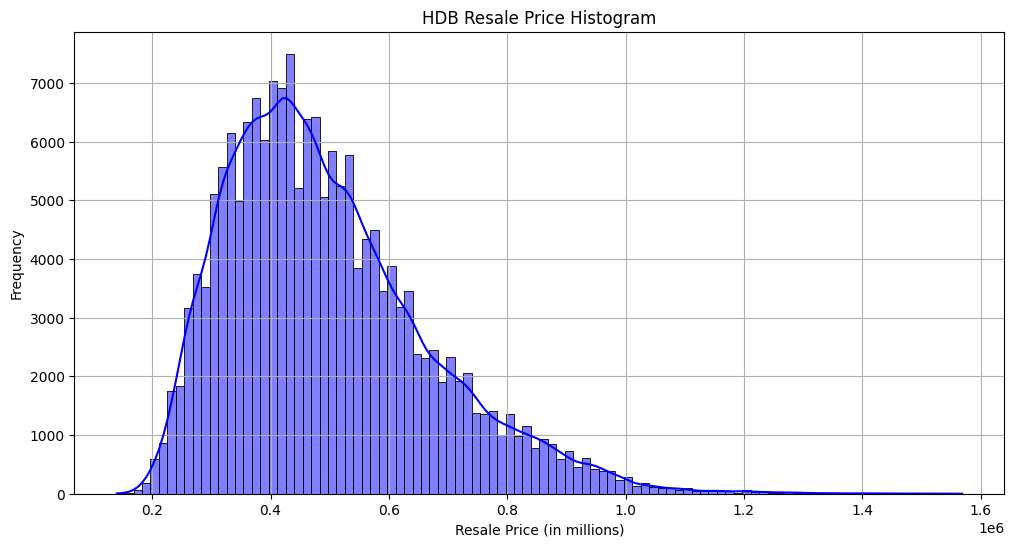

In [ ]:
# 1. HDB Resale Price Histogram.
plt.figure(figsize=(12,6))
sns.histplot(data['Resale_Price'], color = 'blue', bins=100, kde=True)
plt.xlabel('Resale Price (in millions)')
plt.ylabel('Frequency')
plt.title("HDB Resale Price Histogram")


plt.grid(True)
plt.show()

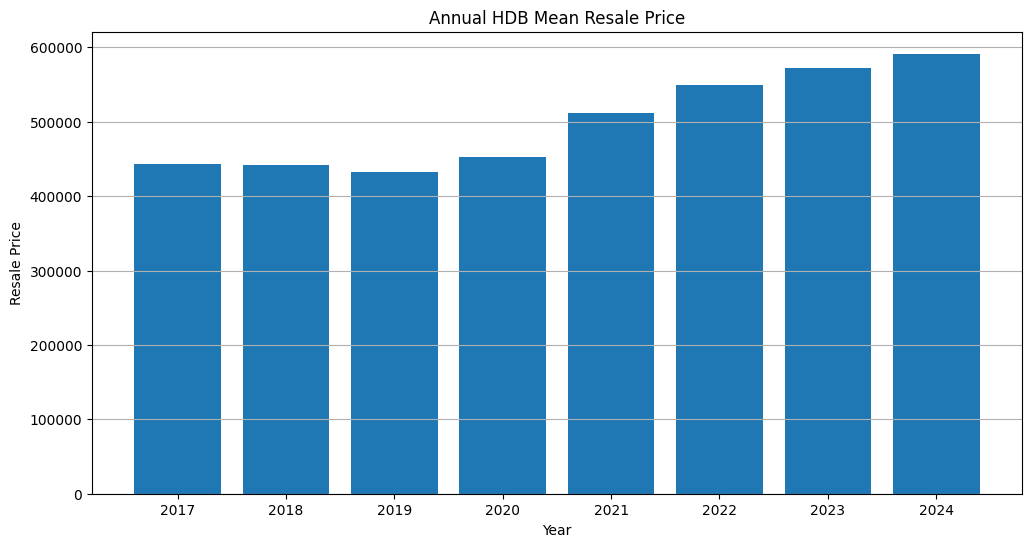

In [ ]:

#Calculating mean and median
mean_ResalePrice = data.groupby('Year')['Resale_Price'].mean()
median_ResalePrice = data.groupby('Year')['Resale_Price'].median()

#Caclulating % changes
mean_change  = mean_ResalePrice.pct_change() * 100
median_change = median_ResalePrice.pct_change()*100


# 2. Yearly Mean Resale Price PlotBar.
plt.figure(figsize=(12,6))
plt.title("Annual HDB Mean Resale Price")
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.bar(mean_ResalePrice.index, mean_ResalePrice )

plt.grid(axis = 'y')
plt.show()


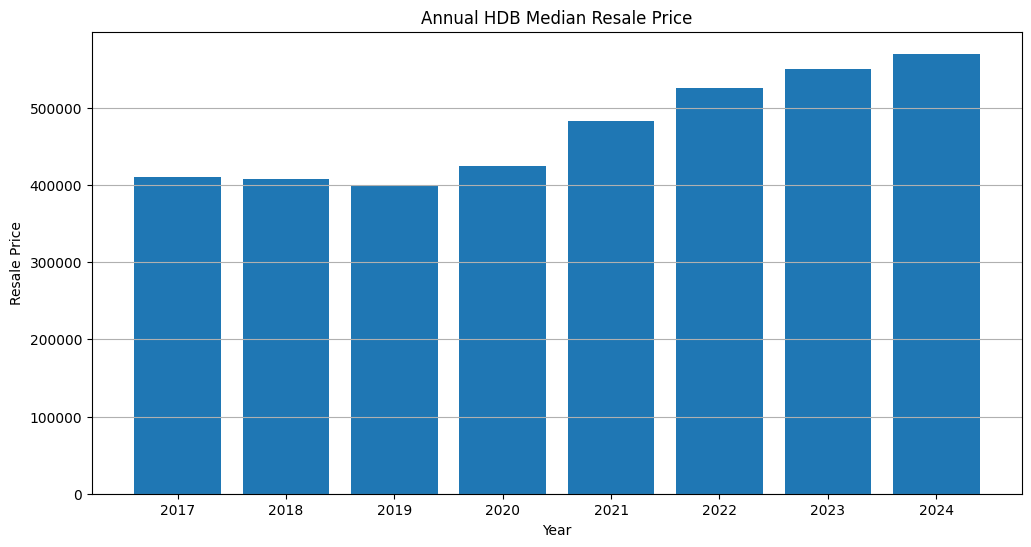

In [ ]:
# 3. Yearly Median Resale Price PlotBar.
plt.figure(figsize=(12,6))
plt.title("Annual HDB Median Resale Price")
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.bar(median_ResalePrice.index, median_ResalePrice )

plt.grid(axis = 'y')
plt.show()


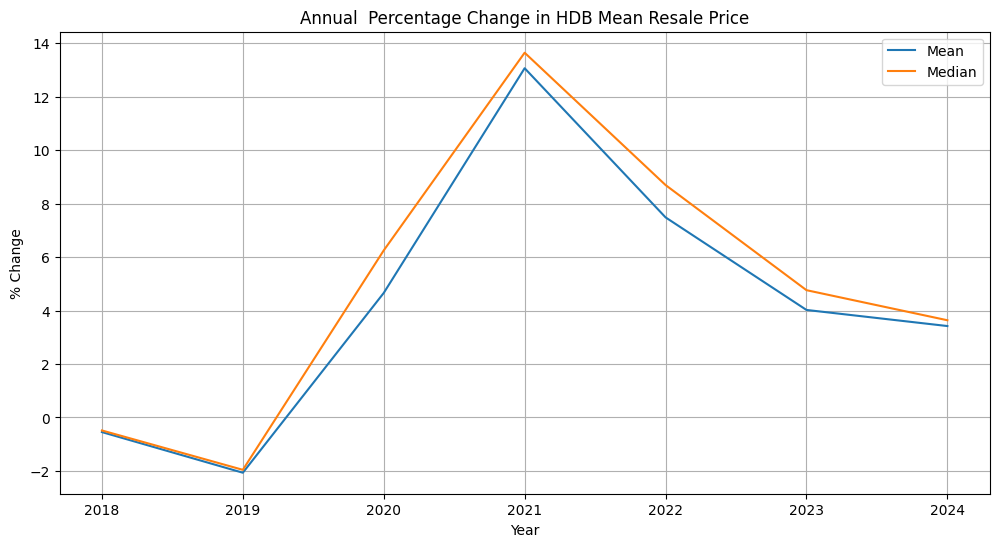

In [ ]:
# 4. Yearly % Change in Mean-Median Resale Price.
plt.figure(figsize=(12,6))
plt.title("Annual  Percentage Change in HDB Mean Resale Price")
plt.xlabel('Year')
plt.ylabel('% Change')
plt.plot(mean_ResalePrice.index, mean_change)
plt.plot(median_ResalePrice.index, median_change)
plt.legend(['Mean', 'Median'])

plt.grid(True)
plt.show()

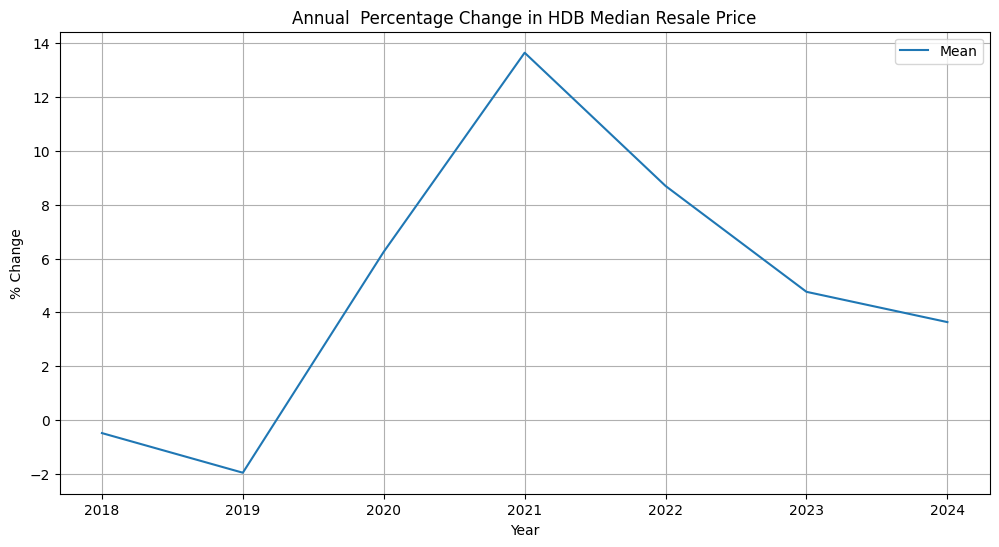

In [ ]:
# 5. Yearly % Change in Median Resale Price.
plt.figure(figsize=(12,6))
plt.title("Annual  Percentage Change in HDB Median Resale Price")
plt.xlabel('Year')
plt.ylabel('% Change')
plt.plot(median_ResalePrice.index, median_change)
plt.legend(['Mean','Median'])

plt.grid(True)
plt.show()

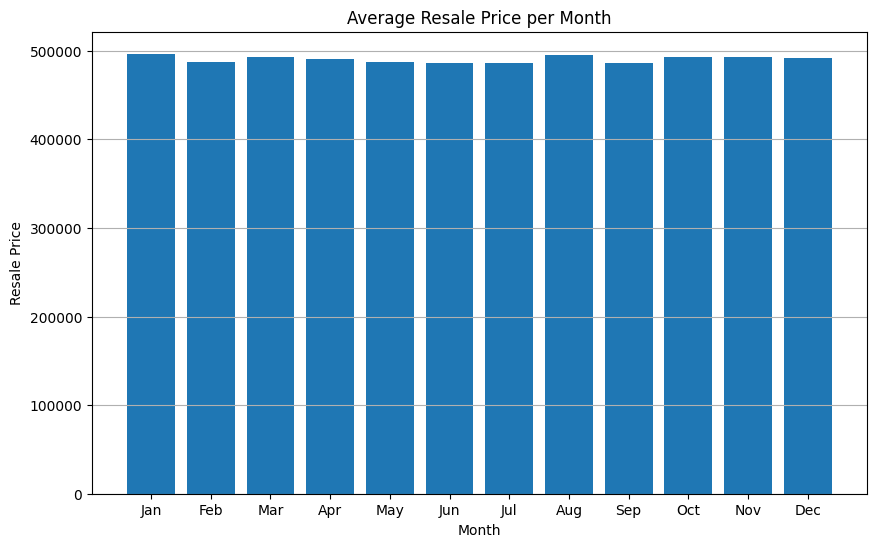

In [ ]:
# Getting Average Month Resale Price.
avg = data.groupby('Month')['Resale_Price'].mean()
avg = avg.reset_index()

avg['Month'] = avg['Month'].dt.strftime('%b') # Converted from (num)Month to name Month.
Avg_Month_Price = avg.groupby('Month')['Resale_Price'].mean()
Avg_Month_Price = Avg_Month_Price.reset_index()
Avg_Month_Price

Month_order = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


# 6. Average Price per Month Barplot.
plt.figure(figsize=(10,6))
plt.title('Average Resale Price per Month')
plt.xlabel('Month')
plt.ylabel('Resale Price')
plt.bar(Avg_Month_Price['Month'], Avg_Month_Price['Resale_Price'])
plt.xticks(Avg_Month_Price['Month'],Month_order)

plt.grid(axis='y')
plt.show()
    # Months dont correlate with resale price, so we will drop them (later) from datetime.

ValueError: Could not interpret value `Flat_Type` for `hue`. An entry with this name does not appear in `data`.

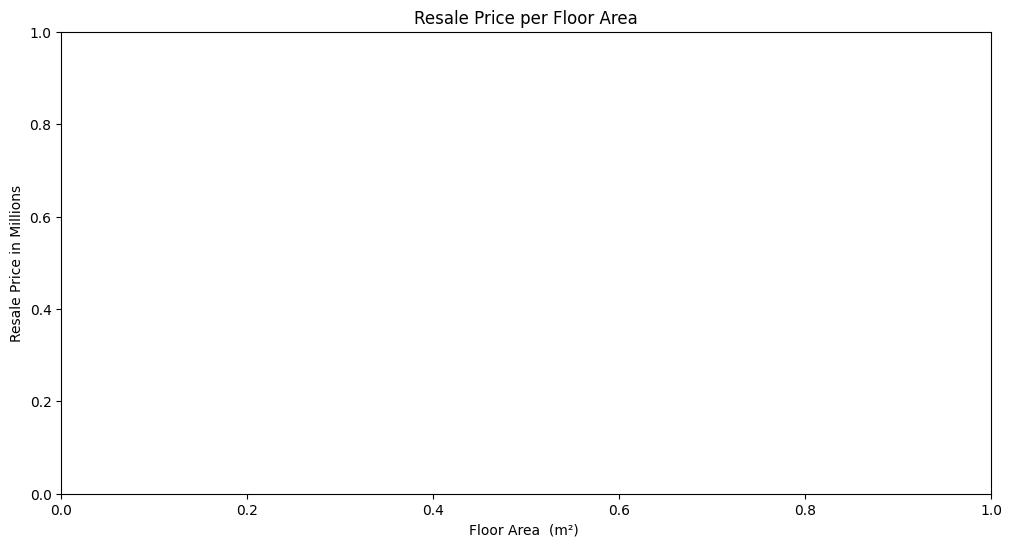

In [ ]:
# 7. Price /Flat Type  Scatterplot.
plt.figure(figsize=(12,6))
plt.xlabel('Floor Area  (m²) ')
plt.ylabel('Resale Price in Millions')
plt.title('Resale Price per Floor Area')
sns.scatterplot(data, x = 'Floor_Area_sqm', y = 'Resale_Price', hue = 'Flat_Type', alpha = 0.4)
sns.regplot(data, x='Floor_Area_sqm', y='Resale_Price', scatter =False,  color ='black' )
plt.tight_layout()

plt.show()
    #High correlation between 'Flat Type' and 'Floor area'.
    #High correlation between 'Price' and 'Floor Area'.


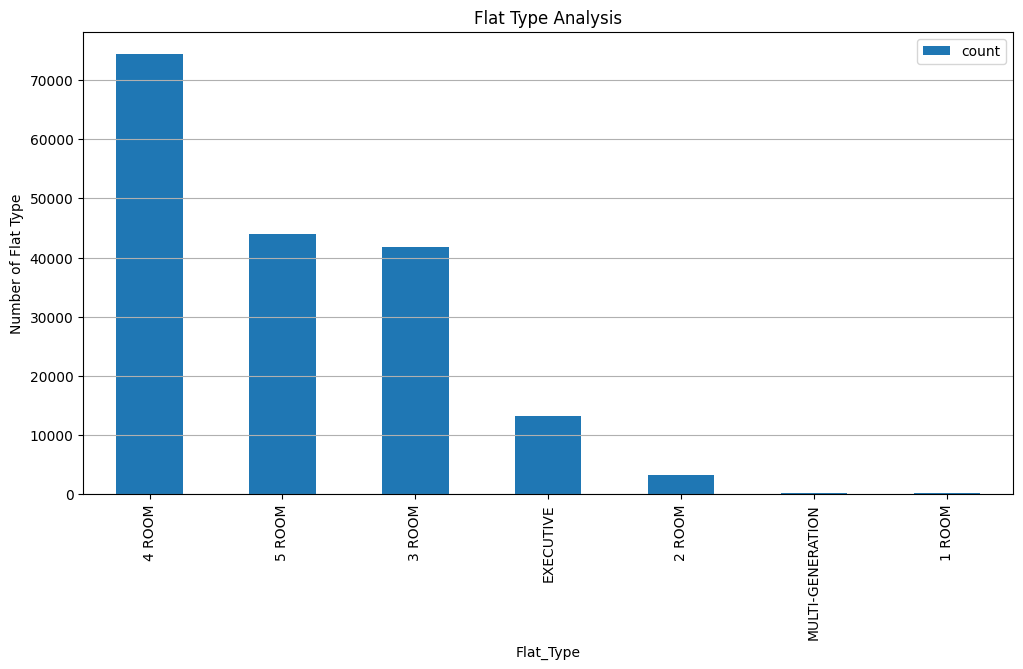

In [ ]:
# 8. Count / Flat Type PieChart.
tmodels_count = data['Flat_Type'].value_counts()
plt.figure(figsize=(12,6))
plt.title("Flat Type Analysis")
plt.xlabel('Flat Types')
plt.ylabel('Number of Flat Type')
tmodels_count.plot(kind='bar')
plt.legend()

plt.grid(axis = 'y')
plt.show()
    # Little, to no transactions on 1-Room & Multi Gen.


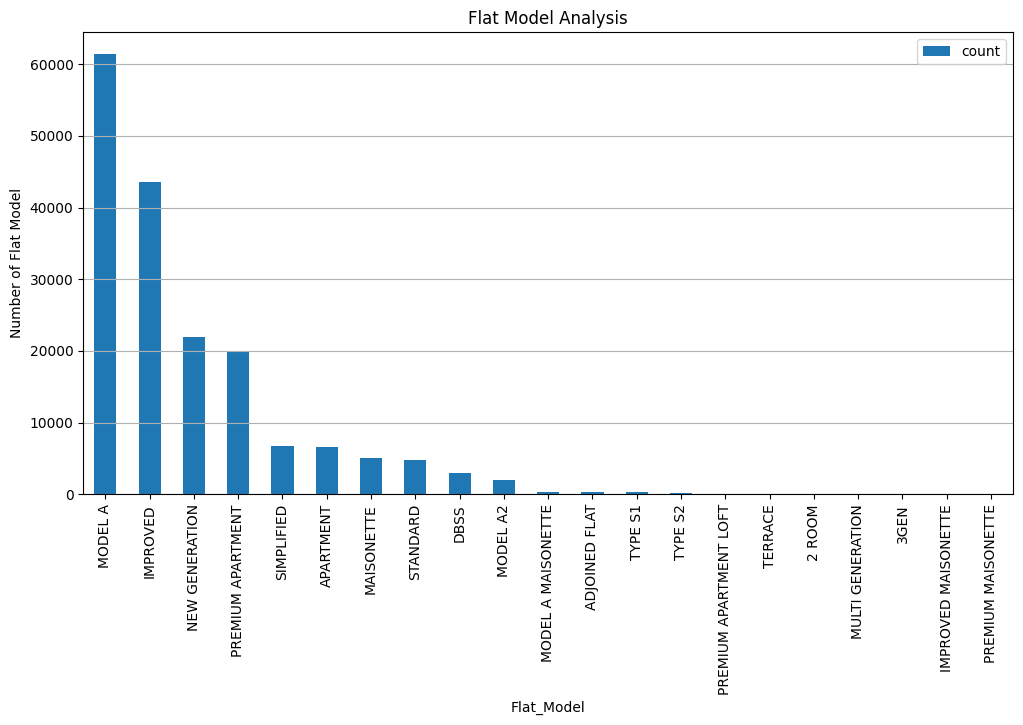

In [ ]:
# 9. Count / Flat Model m² plot.
fmodels_count = data["Flat_Model"].value_counts()
plt.figure(figsize=(12,6))
plt.title("Flat Model Analysis")
plt.xlabel('Flat Models')
plt.ylabel('Number of Flat Model')
fmodels_count.plot(kind='bar')
plt.legend()

plt.grid(axis = 'y')
plt.show()
    #'MODEL A' seems to be the most preferred flat model.

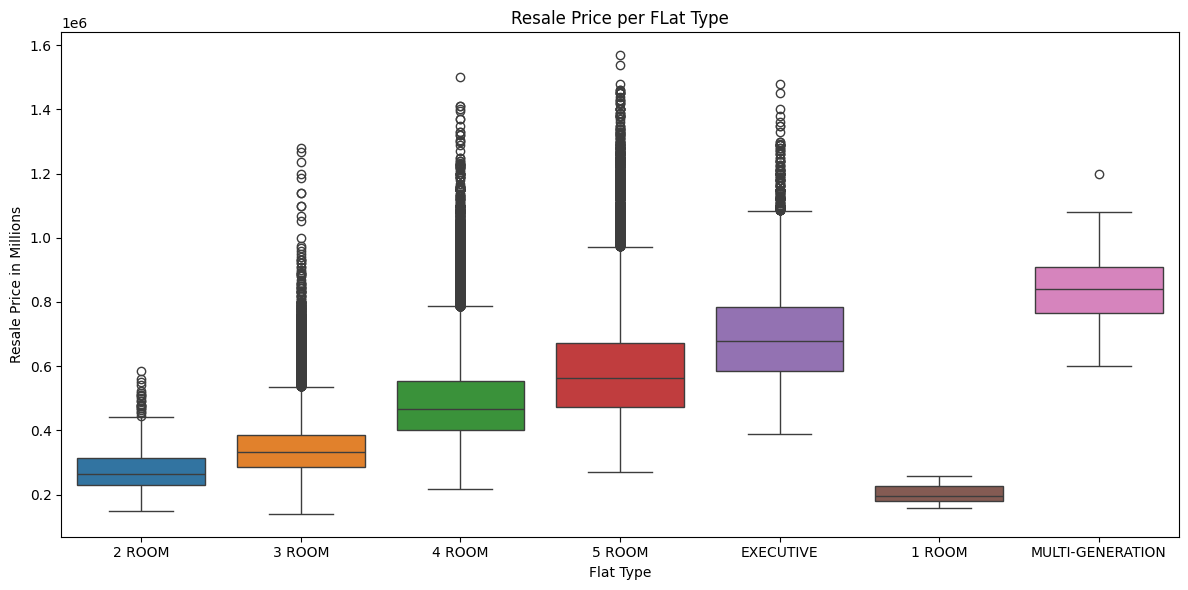

In [ ]:
# 10.Flat_Type  Boxplot
Ftype_order = ['MULTI GENERATION','EXECUTIVE','5 ROOM','4 ROOM','3 ROOM','2 ROOM','1 ROOM']
plt.figure(figsize=(12,6))
plt.title('Resale Price per FLat Type')
plt.ylabel('Resale Price in Millions')
plt.xlabel('Flat Type')
sns.boxplot(data=data, x='Flat_Type', y='Resale_Price', hue = 'Flat_Type')
plt.tight_layout()

plt.show()

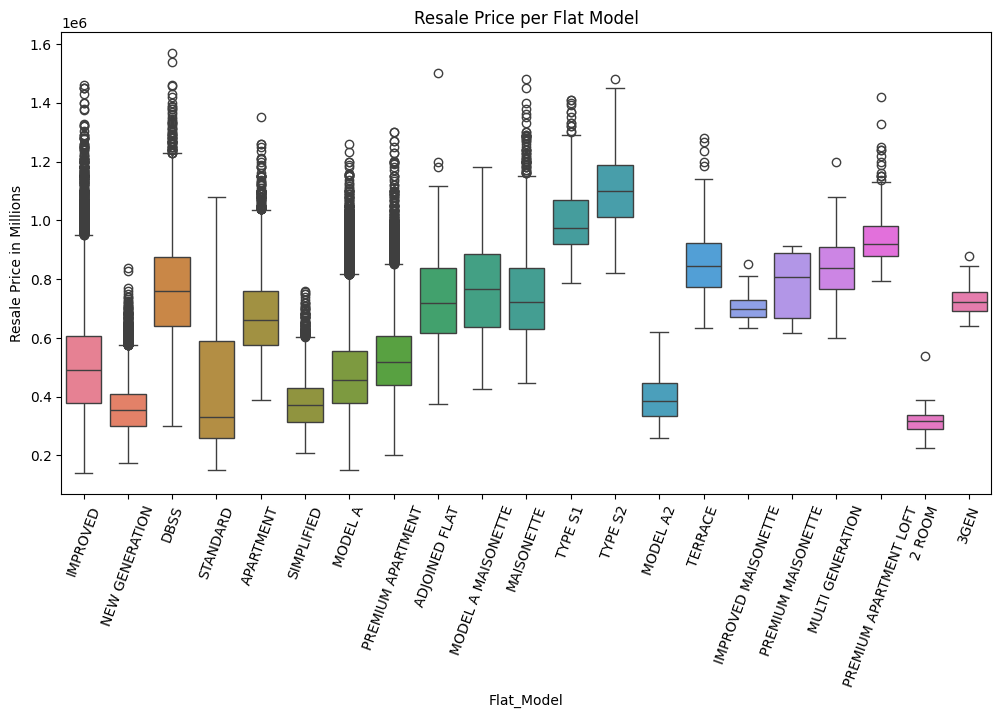

In [ ]:
# 11.Flat_Model Boxplot.
plt.figure(figsize=(12,6))
plt.title('Resale Price per Flat Model')
plt.ylabel('Resale Price in Millions')
plt.xlabel('Flat_Model')
sns.boxplot(data=data, x='Flat_Model', y='Resale_Price', hue = 'Flat_Model', linewidth=1)
plt.xticks(rotation=70)  # Rotate the tick labels by 45 degrees

plt.show()

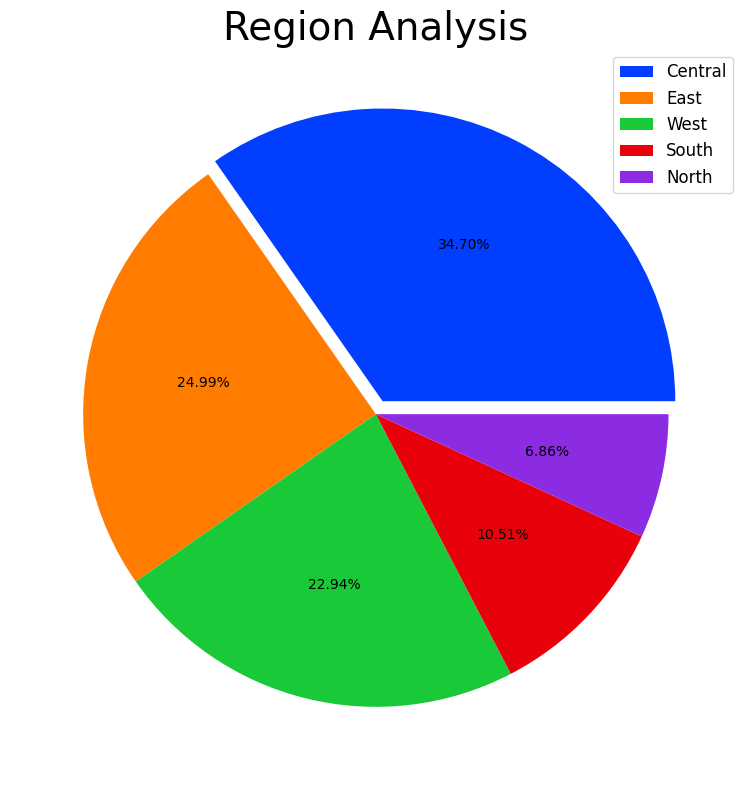

In [ ]:
# 12. Count / Region Pie
clr = sns.color_palette('bright')
exp = (0.05, 0.0, 0.0, 0.0, 0.0)
plt.figure(figsize=(12,8))
plt.title('Region Analysis', fontsize=28)
plt.pie(data['Region'].value_counts(), colors = clr, autopct = "%1.2f%%", explode=exp)
plt.legend(data['Region'].unique(), fontsize='large')
plt.tight_layout()

plt.show()
    # Not many houses at the North & South side of Singapore.

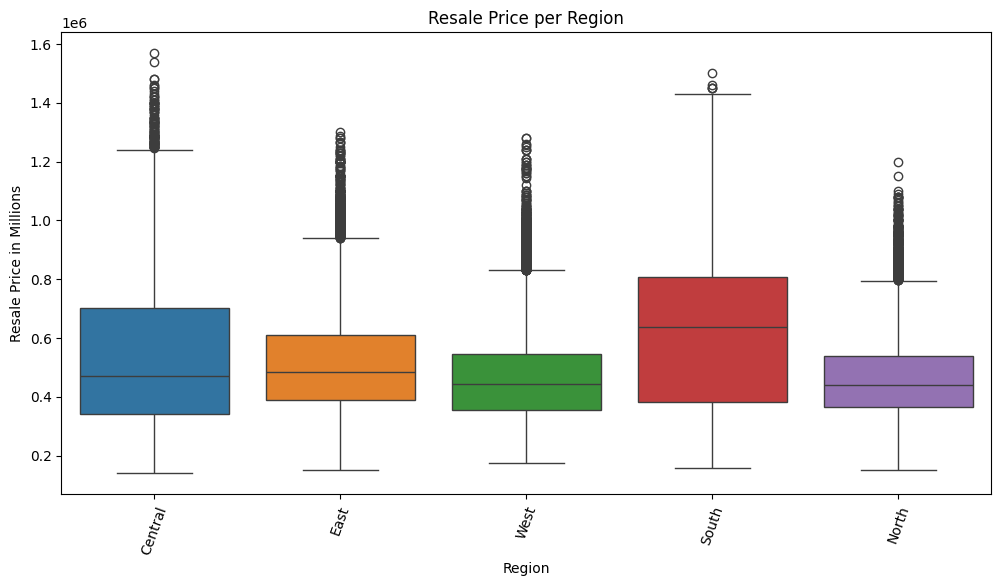

In [ ]:
# 13. Location Boxplot.
plt.figure(figsize=(12,6))
plt.title('Resale Price per Region')
plt.ylabel('Resale Price in Millions')
plt.xlabel('Region')
sns.boxplot(data=data, x='Region', y='Resale_Price',hue='Region')
plt.xticks(rotation=70)

plt.show()

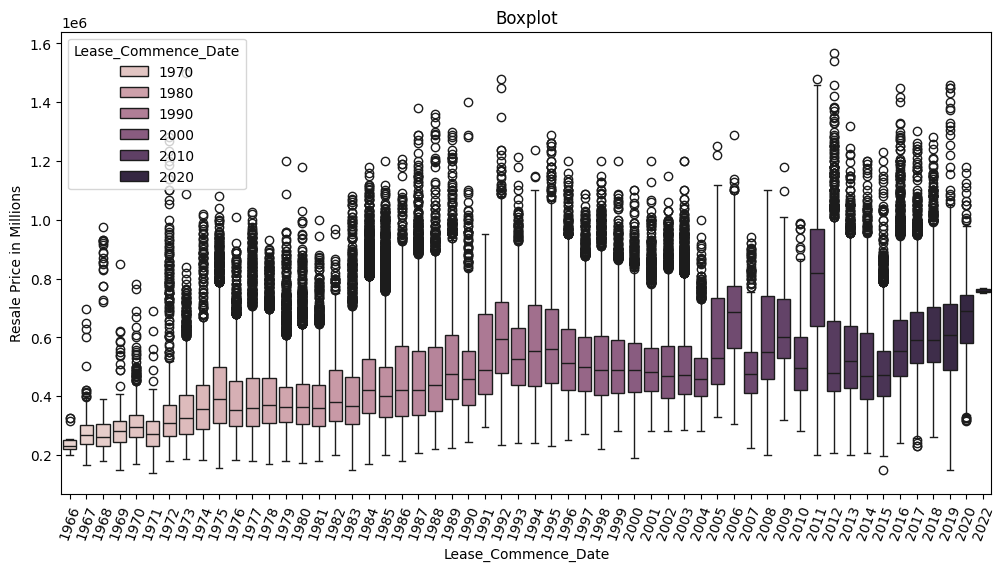

In [ ]:
# 14. Lease Commence Date Boxplot.
plt.figure(figsize=(12,6))
plt.title('Boxplot')
plt.ylabel('Resale Price in Millions')
plt.xlabel('Lease_Commence_Date')
sns.boxplot(data=data, x='Lease_Commence_Date', y='Resale_Price',hue='Lease_Commence_Date')
plt.xticks(rotation=70)

plt.show()

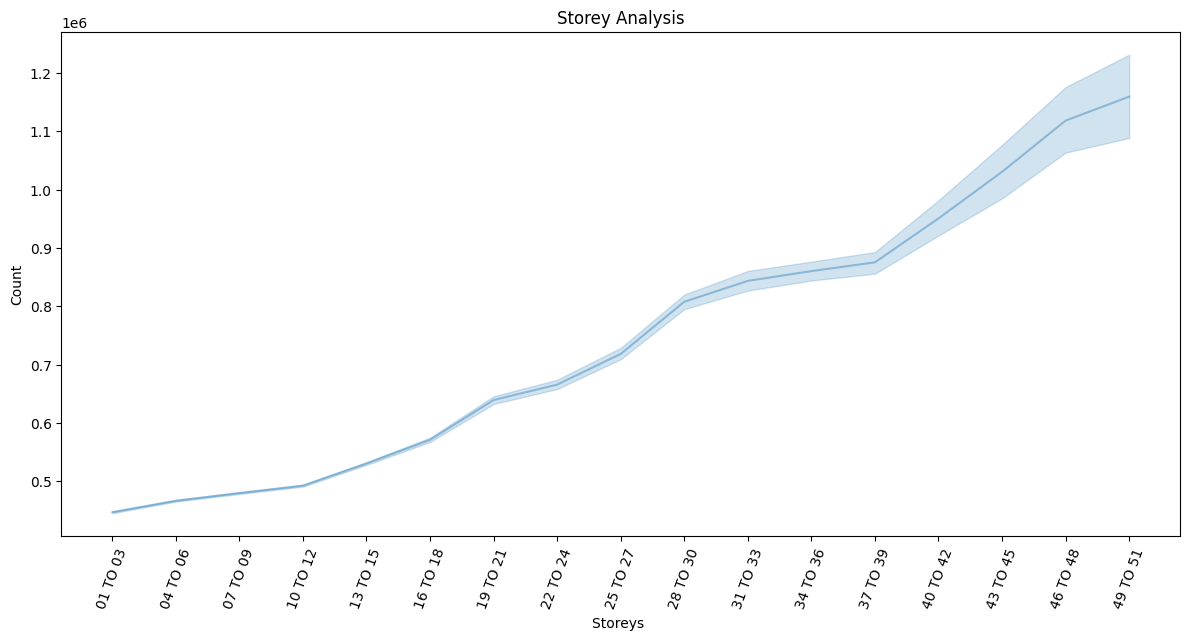

In [ ]:
# 15. Storey Analysis
storey_order = ['01 TO 03','04 TO 06','07 TO 09','10 TO 12','13 TO 15','16 TO 18','19 TO 21','22 TO 24',
                '25 TO 27','28 TO 30','31 TO 33','34 TO 36', '37 TO 39','40 TO 42', '43 TO 45', '46 TO 48', "49 TO 51"]
data['Storey_Range'] = pd.Categorical(data['Storey_Range'], categories=storey_order, ordered=True)

plt.figure(figsize=(12,6))
plt.xlabel('Storeys ')
plt.ylabel('Count')
plt.title('Storey Analysis')
sns.lineplot(data, x = 'Storey_Range', y='Resale_Price' , alpha = 0.4)

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

#========================================================================#

# **========================   Feature Engineering   =======================**

In [ ]:
# Transforming 'Flat Type' Column into 'Room' Column.
def transformRooms(room):
  if room == '1 ROOM':
    return 1
  elif room == '2 ROOM':
    return  2
  elif room == '3 ROOM':
    return 3
  elif room == '4 ROOM':
    return 4
  elif room == '5 ROOM':
    return 5
  elif room == 'EXECUTIVE' or room == 'MULTI GENERATION':
    return 6

data['Rooms'] = data['Flat_Type'].apply(transformRooms)
     # EXECUTIVE & MULTI GENERATION Transformed into 6 Room , Based on HDB Floor Plans: https://www.teoalida.com/singapore/hdbfloorplans/
print("Transformed Room column unique values...")
print(data['Rooms'].unique(), end="\n\n\n")

# Transforming 'Flat Model' Column.
Standard ={'2 ROOM','STANDARD','IMPROVED'}
Apartment = {'PREMIUM APARTMENT LOFT','PREMIUM APARTMENT','APARTMENT'}
Maisonette = {'PREMIUM MAISONETTE','IMPROVED MAISONETTE','MODEL A MAISONETTE', 'MAISONETTE'}
A_Model = {'MODEL A2','SIMPLIFIED', 'MODEL A'}
New_Gen = {'NEW GENERATION','MULTI GENERATION','3GEN'}
Exclusive = {'TERRACE','TYPE S1', 'TYPE S2','ADJOINED FLAT', 'DBSS'}

def transformModels(model):
  if model in Standard:
    return 'Standard'
  elif model in Apartment:
    return  'Apartment'
  elif model in Maisonette:
    return 'Maisonette'
  elif model in A_Model:
    return 'A model'
  elif model in New_Gen:
    return 'New Generation'
  elif model in Exclusive:
    return 'Exclusive'

data['Flat_Model'] = data['Flat_Model'].apply(transformModels)
  # From 21 categorial values, we have only 6.
print("Transformed Flat Model column unique values...")
print(data['Flat_Model'].unique(), end="\n\n\n")

# Transforming 'Storey Range' Column into 'Storey Level' Column.
Low = {'01 TO 03 ','04 TO 06'}
Medium = {'07 TO 09','10 TO 12'}


def transformStoreys(level):
  if level in Low:
    return 'Low'
  elif level in Medium:
    return  'Medium'
  else:
    return 'High'

data['Storey_Level'] = data['Storey_Range'].apply(transformStoreys)
    # From 17 categorial values,now, we have only 3.
print("Transformed Storey Range column into Storey Level, unique values...")
print(data['Storey_Level'].unique(), end="\n\n\n")




Transformed Room column unique values...
[2 3 4 5 6 1]


Transformed Flat Model column unique values...
['Standard' 'New Generation' 'Exclusive' 'Apartment' 'A model'
 'Maisonette']


Transformed Storey Range column into Storey Level, unique values...
['Medium' 'High' 'Low']




In [ ]:
# Dropping 'Month' Column ---> Keeping 'Year' Instead.
data = data.drop('Month', axis=1)

# Dropping 'Town', 'Block', 'Street Name' Columns ---> Keeping 'Region' Instead.
cols =['Town', 'Block', 'Street_Name']
data = data.drop(columns = cols)

# Dropping 'Remaining Lease' Column ---> Keeping 'Lease Commence Date'.
data = data.drop('Remaining_Lease', axis=1)

# Dropping 'Flat Type' ---> Transformed into 'Rooms' Column
# Dropping 'Storey Range' ---> Transformed into 'Storey Level' Column.
cols =['Flat_Type',  'Storey_Range']
data = data.drop(columns = cols)
data = data[['Year','Region','Rooms','Flat_Model','Floor_Area_sqm','Storey_Level','Lease_Commence_Date','Resale_Price']]
print("Daraframe :")
data.head()

Daraframe :


,Year,Region,Rooms,Flat_Model,Floor_Area_sqm,Storey_Level,Lease_Commence_Date,Resale_Price
0,2017,Central,2,Standard,44.0,Medium,1979,232000.0
1,2017,Central,3,New Generation,67.0,High,1978,250000.0
2,2017,Central,3,New Generation,67.0,High,1980,262000.0
3,2017,Central,3,New Generation,68.0,Low,1980,265000.0
4,2017,Central,3,New Generation,67.0,High,1980,265000.0


In [ ]:
# One-Hot Encoding 'Region' Column.
# Ordinal Encoding 'Flat Model' & 'Storey' Columns.

Fmodel_values = {'Standard':4, 'New Generation':0, 'Apartment':3, 'Maisonette':5, 'A model':1, 'Exclusive':2}
Storey_values = {'Low':0, "Medium":1, "High":2}

encoded_data = pd.get_dummies(data, columns=['Region'], prefix="Region")
encoded_data = encoded_data.replace({'Flat_Model': Fmodel_values})
encoded_data = encoded_data.replace({'Storey_Level': Storey_values})


# Converting True/Flase to 0/1.
columns = ['Region_North', 'Region_East', 'Region_West', 'Region_South', 'Region_Central']
for cols in columns:
  encoded_data[cols] = encoded_data[cols].astype(int)

unscaled_data = encoded_data
print("Encoded data without scaling...")
unscaled_data.head()

Encoded data without scaling...


,Year,Rooms,Flat_Model,Floor_Area_sqm,Storey_Level,Lease_Commence_Date,Resale_Price,Region_Central,Region_East,Region_North,Region_South,Region_West
0,2017,2,4,44.0,1,1979,232000.0,1,0,0,0,0
1,2017,3,0,67.0,2,1978,250000.0,1,0,0,0,0
2,2017,3,0,67.0,2,1980,262000.0,1,0,0,0,0
3,2017,3,0,68.0,0,1980,265000.0,1,0,0,0,0
4,2017,3,0,67.0,2,1980,265000.0,1,0,0,0,0


In [ ]:
# Standardization
scaler = StandardScaler()
columns = ['Lease_Commence_Date','Floor_Area_sqm','Year','Rooms','Flat_Model','Storey_Level']
scaler.fit(encoded_data[columns])
columns = pd.DataFrame(scaler.transform(encoded_data[columns]), index = encoded_data.index, columns = columns)

# Drop Unscaled Columns.
dropped_cols = encoded_data.drop(columns, axis = 1)
scaled_data = pd.concat([columns, dropped_cols], axis=1)
print("Scaled data...")
scaled_data.head()

Scaled data...


,Lease_Commence_Date,Floor_Area_sqm,Year,Rooms,Flat_Model,Storey_Level,Resale_Price,Region_Central,Region_East,Region_North,Region_South,Region_West
0,-1.211795,-2.214295,-1.622632,-2.316164,1.198147,-0.187470,232000.0,1,0,0,0,0
1,-1.283195,-1.257101,-1.622632,-1.227108,-1.384194,1.122269,250000.0,1,0,0,0,0
2,-1.140395,-1.257101,-1.622632,-1.227108,-1.384194,1.122269,262000.0,1,0,0,0,0
3,-1.140395,-1.215484,-1.622632,-1.227108,-1.384194,-1.497209,265000.0,1,0,0,0,0
4,-1.140395,-1.257101,-1.622632,-1.227108,-1.384194,1.122269,265000.0,1,0,0,0,0


In [ ]:
# Removing outliers from each Column  with IQR method.
# The function is called once for each column of the data frame.
def remove_outliers(data,column):

   # Defining 1st & 3rd quartiles.
   Q1 = data[column].quantile(0.25)
   Q3 = data[column].quantile(0.75)

   IQR = Q3 - Q1

   # Defining the upper/lower bound for outlier.
   lower_limit = Q1 - 1.5* IQR
   upper_limit = Q3 + 1.5* IQR

   #Removing outliers.
   min_cap = data[column] >= lower_limit
   max_cap = data[column] <= upper_limit
   clear_data = data[ min_cap & max_cap ]

   return clear_data

# Created an empty dictionary and stored the outlier counts for each column of scaled dataset.
dict_out1 = {}
for column in scaled_data.columns:
   clear_scaled_data = remove_outliers(scaled_data,column)
   outliers = len(scaled_data) - len(clear_scaled_data)
   dict_out1[column] = outliers


df_scaled_outliers = pd.DataFrame.from_dict(dict_out1, orient = 'index', columns = ['Outliers'] )

percentage =(scaled_data.shape[0] - clear_scaled_data.shape[0])*100 / scaled_data.shape[0]

(scaled_data.shape[0] - clear_scaled_data.shape[0])
# Created an empty dictionary and stored the outlier counts for each column of unscaled dataset.
dict_out2 = {}
for column in unscaled_data.columns:
   clear_unscaled_data = remove_outliers(unscaled_data,column)
   outliers = unscaled_data.shape[0] - clear_unscaled_data.shape[0]
   dict_out2[column] = outliers

df_unscaled_outliers = pd.DataFrame.from_dict(dict_out2, orient = 'index', columns = ['Outliers'] )

print(f"The percentage of outliers removed from the  dataframe is: {percentage:.3f}%", end = '\n\n')
print(f"Dataset shape before IQR methon : {unscaled_data.shape}", end ="\n\n")
print(f"Dataset shape after IQR methon : {clear_unscaled_data.shape}", end ="\n\n")
print(f"Insances deleted : {scaled_data.shape[0] - clear_scaled_data.shape[0]}", end = "\n\n" )


#=================================================================================#

The percentage of outliers removed from the  dataframe is: 22.941%

Dataset shape before IQR methon : (176693, 12)

Dataset shape after IQR methon : (136157, 12)

Insances deleted : 40536



# **=========================Model Training=========================**

In [ ]:
c


In [ ]:
# Splitting Dataset.
y = clear_unscaled_data[['Resale_Price']]
x = clear_unscaled_data.drop(['Resale_Price'], axis=1)
Y = clear_scaled_data[['Resale_Price']]
X = clear_scaled_data.drop(['Resale_Price'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, shuffle=True, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, shuffle=True, random_state=0)

In [ ]:
print ("------------Lasso Regression---------------")
print (end="\n\n")


# Lasso Regression without Standardization
lasso1 = Lasso(alpha=1.0)
lasso1.fit(x_train,y_train)
lasso1_pred_test = lasso1.predict(x_test)
lasso1_pred_train = lasso1.predict(x_train)

r2_lasso1_test =r2_score(y_test, lasso1_pred_test)
r2_lasso1_train =r2_score(y_train, lasso1_pred_train)
mae_lasso1 = mean_absolute_error(y_test, lasso1_pred_test)
mse_lasso1 = mean_squared_error(y_test, lasso1_pred_test)
rmse_lasso1 = np.sqrt(mse_lasso1)



print("Mean MSE without Stardadization and Hypetuning:", mse_lasso1)
print("Mean RMSE without Stardadization and Hypetuning:", rmse_lasso1)
print("Mean MAE without Stardadization and Hypetuning:", mae_lasso1)
print(f"Mean R-squared without Stardadization and Hypetuning:{ r2_lasso1_test:.5f}")
print (end="\n\n\n")

------------Lasso Regression---------------


Mean MSE without Stardadization and Hypetuning: 8102777605.700756
Mean RMSE without Stardadization and Hypetuning: 90015.42982011892
Mean MAE without Stardadization and Hypetuning: 68161.25938056961
Mean R-squared without Stardadization and Hypetuning:0.74072





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+13, tolerance: 3.877e+11
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Lasso Regresson with Stardadization and Hypetuning
parameters = { 'alpha' : [1.0, 1.5, 2.0, 2.5],
               'max_iter' : [1500, 2000, 2500]}

lasso2 = Lasso()
estimators = GridSearchCV(lasso2, param_grid = parameters, cv=30, n_jobs = -1 )
best_est = estimators.fit(X_train,Y_train)
print("\n The best estimator across searched parameters:\n\n",best_est.best_estimator_)

best_lasso2  = Lasso(alpha = 2.5, max_iter=1500)
best_lasso2.fit(X_train, Y_train)
lasso2_pred_test = best_lasso2.predict(X_test)
lasso2_pred_train = best_lasso2.predict(X_train)

mse_lasso2 =mean_squared_error(Y_test, lasso2_pred_test)
rmse_lasso2 = np.sqrt(mse_lasso2)
mae_lasso2 = mean_absolute_error(Y_test, lasso2_pred_test)
r2_lasso2_test =r2_score(Y_test, lasso2_pred_test)

print("Mean MSE with Stardadization and Hypetuning:", mse_lasso2)
print("Mean RMSE with Stardadization and Hypetuning:", rmse_lasso2)
print("Mean MAE with Stardadization and Hypetuning:", mae_lasso2)
print(f"Mean R-squared with Stardadization and Hypetuning:{ r2_lasso2_test:.5f}")
print (end="\n\n\n")
#23min

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+13, tolerance: 4.690e+11
  model = cd_fast.enet_coordinate_descent(



 The best estimator across searched parameters:
 Lasso(alpha=2.5, max_iter=1500)
Mean MSE with Stardadization and Hypetuning: 8057935849.264131
Mean RMSE with Stardadization and Hypetuning: 89766.00608952217
Mean MAE with Stardadization and Hypetuning: 67483.25850434865
Mean R-squared with Stardadization and Hypetuning:0.72520





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+13, tolerance: 4.690e+11
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print ("------------Ridge Regression---------------")
print (end="\n\n")


# Ridge Regression without Standardization
ridge1 = Ridge(alpha=1.0)
ridge1.fit(x_train,y_train)
ridge1_pred_test = ridge1.predict(x_test)

mse_ridge1 =mean_squared_error(y_test, ridge1_pred_test)
rmse_ridge1 = np.sqrt(mse_ridge1)
mae_ridge1 =mean_absolute_error(y_test, ridge1_pred_test)
r2_ridge1_test =r2_score(y_test, ridge1_pred_test)

print("Mean MSE without Stardadization and Hypetuning:", mse_ridge1)
print("Mean RMSE without Stardadization and Hypetuning:", rmse_ridge1)
print("Mean MAE without Stardadization and Hypetuning:", mae_ridge1)
print(f"Mean R-squared without Stardadization and Hypetuning:{ r2_ridge1_test:.5f}")
print (end="\n\n")

------------Ridge Regression---------------


------------Ridge Regression---------------
Mean MSE without Stardadization and Hypetuning: 8102777051.038328
Mean RMSE without Stardadization and Hypetuning: 90015.42673918915
Mean MAE without Stardadization and Hypetuning: 68161.1722295153
Mean R-squared without Stardadization and Hypetuning:0.74072




In [ ]:
# Ridge Regresson with Stardadization and Hypetuning
parameters = {'alpha' : [1.0, 1.5, 2.0, 2.5],
              'max_iter' : [400,500,600,700,800]}

ridge2 = Ridge()
estimators = GridSearchCV(ridge2, param_grid = parameters, n_jobs = -1 )
best_est = estimators.fit(X_train,Y_train)
print("\n The best estimator across searched parameters:\n\n",best_est.best_estimator_)

best_ridge2  = Ridge(alpha=2.5, max_iter=400)
best_ridge2.fit(X_train, Y_train)
ridge2_pred_test = best_ridge2.predict(X_test)
ridge2_pred_train = best_ridge2.predict(X_train)

r2_ridge2_train =r2_score(Y_train, ridge2_pred_train)
r2_ridge2_test =r2_score(Y_test, ridge2_pred_test)
mae_ridge2 = mean_absolute_error(Y_test, ridge2_pred_test)
mse_ridge2 = mean_squared_error(Y_test, ridge2_pred_test)
rmse_ridge2 = np.sqrt(mse_ridge2)

print(f"Mean MSE with Stardadization and Hypetuning: {int(mse_ridge2)}")
print(f"Mean RMSE with Stardadization and Hypetuning: {int(rmse_ridge2)}")
print(f"Mean MAE with Stardadization and Hypetuning: {int(mae_ridge2)}")
print(f"Mean R-squared with Stardadization and Hypetuning:{ r2_ridge2_test:.5f}")
print (end="\n\n")
#6s


 The best estimator across searched parameters:

 Ridge(alpha=2.0, max_iter=400)
Mean MSE with Stardadization and Hypetuning: 8102758727
Mean RMSE with Stardadization and Hypetuning: 90015
Mean MAE with Stardadization and Hypetuning: 68160
Mean R-squared with Stardadization and Hypetuning:0.74072




In [ ]:
print ("------------Random Forest---------------")
print (end="\n\n")


# Random Forest without Standardization  A column-vector y was passed when a 1d array was expected
forest1 = RandomForestRegressor()
y_1D_train = np.ravel(y_train)
forest1.fit(x_train,y_1D_train)
forest_pred_test = forest1.predict(x_test)
forest_pred_train = forest1.predict(x_train)

r2_forest1_test =r2_score(y_test, forest_pred_test)
r2_forest1_train =r2_score(y_train, forest_pred_train)
mae_forest1 = mean_absolute_error(y_test, forest_pred_test)
mse_forest1 = mean_squared_error(y_test, forest_pred_test)
rmse_forest1 = np.sqrt(mse_forest1)

print("Mean MSE without Stardadization and Hypetuning:", mse_forest1)
print("Mean RMSE without Stardadization and Hypetuning:", rmse_forest1)
print("Mean MAE without Stardadization and  Hypetuning:", mae_forest1)
print(f"Mean R-squared without Stardadization and Hypetuning:{ r2_forest1_test:.5f}")
print (end="\n\n")
#30s

------------Random Forest---------------


Mean MSE without Stardadization and Hypetuning: 2556573684.9976854
Mean RMSE without Stardadization and Hypetuning: 50562.57197767619
Mean MAE without Stardadization and  Hypetuning: 34287.07482503744
Mean R-squared without Stardadization and Hypetuning:0.91819




In [ ]:
#Random Forest with Standardization and HyperParameter Tuning
parameters = {'n_estimators' : [500,1000,1500],
              'max_depth' : [None],
              'min_samples_split' : [20],
              'min_samples_leaf' : [2],
              'max_features' : ['sqrt','log2',None]}

Y_1D_train = np.ravel(Y_train)
forest2 = RandomForestRegressor()
estimators = GridSearchCV(forest2, param_grid = parameters,n_jobs = -1 )
best_est = estimators.fit(X_train,Y_1D_train)
print("\n The best estimator across searched parameters:\n",best_est.best_estimator_)

best_forest2 = RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=2,min_samples_split=20, n_estimators=1000)
best_forest2.fit(X_train,Y_1D_train)
forest_pred_test = best_forest2.predict(X_test)
forest_pred_train = best_forest2.predict(X_train)
r2_forest2_test =r2_score(Y_test, forest_pred_test)
r2_forest2_train =r2_score(Y_train, forest_pred_train)

r2_forest2_test =r2_score(Y_test, forest_pred_test)
r2_forest2_train =r2_score(Y_train, forest_pred_train)
mae_forest2 = mean_absolute_error(Y_test, forest_pred_test)
mse_forest2 = mean_squared_error(Y_test, forest_pred_test)
rmse_forest2 = np.sqrt(mse_forest2)

print("Mean MSE with Stardadization and Hypetuning:", mse_forest2)
print("Mean RMSE with Stardadization and Hypetuning:", rmse_forest2)
print("Mean MAE with Stardadization and Hypetuning:", mae_forest2)
print(f"Mean R-squared with Stardadization and Hypetuning:{ r2_forest2_test:.5f}")
print (end="\n\n")

#79min


 The best estimator across searched parameters:
 RandomForestRegressor(max_features=None, min_samples_leaf=2,
                      min_samples_split=20, n_estimators=1500)
Mean MSE with Stardadization and Hypetuning: 2578884898.5006585
Mean RMSE with Stardadization and Hypetuning: 50782.722440813064
Mean MAE with Stardadization and Hypetuning: 34928.95983168954
Mean R-squared with Stardadization and Hypetuning:0.91748




In [ ]:
print ("------------Decision Tree---------------")
print (end="\n\n")



# Decision Tree without Standardization
y_1D_train = np.ravel(y_train)
tree1 = DecisionTreeRegressor()
tree1.fit(x_train,y_1D_train)
tree_pred_test = tree1.predict(x_test)
tree_pred_train = tree1.predict(x_train)

r2_tree1_test =r2_score(y_test, tree_pred_test)
r2_tree1_train =r2_score(y_train, tree_pred_train)
mae_tree1 = mean_absolute_error(y_test, tree_pred_test)
mse_tree1 = mean_squared_error(y_test, tree_pred_test)
rmse_tree1 = np.sqrt(mse_tree1)

print("Mean MSE without Stardadization and Hypetuning:", mse_tree1)
print("Mean RMSE without Stardadization and Hypetuning:", rmse_tree1)
print("Mean MAE without Stardadization and Hypetuning:", mae_tree1)
print(f"Mean R-squared without Stardadization and Hypetuning:{ r2_tree1_test:.5f}")
print (end="\n\n")

------------Decision Tree---------------


Mean MSE without Stardadization and Hypetuning: 2918838039.4409394
Mean RMSE without Stardadization and Hypetuning: 54026.27175218497
Mean MAE without Stardadization and Hypetuning: 36086.71612148944
Mean R-squared without Stardadization and Hypetuning:0.90660




In [ ]:
# Decision Tree with Standardization and HyperParameter Tuning

parameters = {'splitter' : ['best', 'random'],
              'max_depth' : [15,20,22,25],
              'min_samples_split' : [20,25,30],
              'min_samples_leaf' : [2,3,4],
              'max_features' : ['sqrt','log2',None]}

Y_1D_train = np.ravel(Y_train)
tree2 = DecisionTreeRegressor()
estimators = GridSearchCV(tree2, param_grid = parameters,n_jobs = -1 )
best_est = estimators.fit(X_train,Y_1D_train)
print("\n The best estimator across searched params:\n",best_est.best_estimator_)

best_tree2 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=20)
best_tree2.fit(x_train,y_1D_train)
tree_pred_test = best_tree2.predict(x_test)
tree_pred_train = best_tree2.predict(x_train)

r2_tree2_test =r2_score(y_test, tree_pred_test)
r2_tree2_train =r2_score(y_train, tree_pred_train)
mae_tree2 = mean_absolute_error(y_test, tree_pred_test)
mse_tree2 = mean_squared_error(y_test, tree_pred_test)
rmse_tree2 = np.sqrt(mse_tree1)

print("Mean MSE without Stardadization and Hypetuning:", mse_tree1)
print("Mean RMSE without Stardadization and Hypetuning:", rmse_tree1)
print("Mean MAE without Stardadization and Hypetuning:", mae_tree1)
print(f"Mean R-squared without Stardadization and Hypetuning:{ r2_tree1_test:.5f}")

#2min


 The best estimator across searched params:
 DecisionTreeRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=20)
Mean MSE without Stardadization and Hypetuning: 2918838039.4409394
Mean RMSE without Stardadization and Hypetuning: 54026.27175218497
Mean MAE without Stardadization and Hypetuning: 36086.71612148944
Mean R-squared without Stardadization and Hypetuning:0.90660
